In [41]:
import pandas as pd

# Load data from CSV file
data = pd.read_csv('../../DATASET/QCG.csv')

# Preprocess data
# Covert volume from string to number
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Apply convert_volume_to_number function to Volume column
data["Volume"] = data["Volume"].apply(convert_volume_to_number)

# Covert change % from string to number
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Apply convert_change_to_number function to Change % column
data["Change %"] = data["Change %"].apply(convert_change_to_number)

# Function to convert string to number
def convert_str_to_number(str):
    return float(str.replace(',', ''))


# Apply convert_str_to_number function to Close, Open, High, Low columns
data['Close'] = data['Close'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)
data

,Date,Close,Open,High,Low,Volume,Change %
0,1/3/2024,18450.0,18300.0,18500.0,18150.0,9350000,0.0110
1,29/02/2024,18250.0,18150.0,18400.0,18050.0,13440000,0.0111
2,28/02/2024,18050.0,18300.0,18350.0,18000.0,6990000,-0.0082
3,27/02/2024,18200.0,18000.0,18300.0,17800.0,11250000,0.0196
4,26/02/2024,17850.0,18100.0,18150.0,17650.0,9100000,-0.0165
...,...,...,...,...,...,...,...
1247,7/3/2019,17092.0,17912.4,17912.4,17092.0,3840000,-0.0329
1248,6/3/2019,17673.2,17502.2,17741.5,17365.5,1640000,0.0098
1249,5/3/2019,17502.2,17775.7,17912.4,17365.5,3490000,-0.0173
1250,4/3/2019,17809.9,17228.8,17878.3,17092.0,5540000,0.0441


In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [43]:
df = data
df = df[['Close']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [44]:
import sys, os
try:
    import pdarima as pda
except:
    os.system("pip install pmdarima")

from pmdarima.arima import auto_arima

In [45]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14080.143, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14084.082, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14079.039, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14078.372, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14082.274, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14076.610, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=14078.539, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=14078.571, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=14078.516, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=14079.282, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=14074.760, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=14076.549, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=14077.221, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=14076.682, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [46]:
# 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [47]:
# Predict the closing prices for the next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[8723.24588946 8707.29746895 8716.53122839 8711.18509939 8714.28038203
 8712.48828636 8713.5258675  8712.92513248 8713.27294389 8713.07156929
 8713.18816043 8713.12065691 8713.15973986 8713.13711175 8713.15021289
 8713.14262764 8713.14701932 8713.14447664 8713.14594879 8713.14509645
 8713.14558994 8713.14530422 8713.14546965 8713.14537387 8713.14542932
 8713.14539722 8713.1454158  8713.14540504 8713.14541127 8713.14540767]


In [48]:
# Convert y_val and y_test to numeric
y_val = pd.to_numeric(y_val, errors='coerce')
y_test = pd.to_numeric(y_test, errors='coerce')

# Calculate RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 5139.574704226175
Testing RMSE: 3132.203259312926


Validation RMSE: 5139.574704226175
Testing RMSE: 3132.203259312926


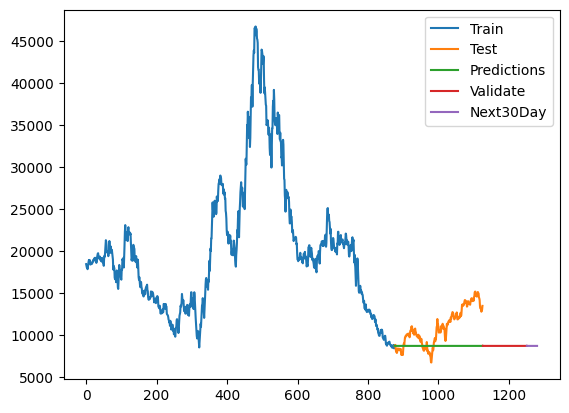

In [49]:
# Calculate RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# Plot the data
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

In [50]:
test_data.index

RangeIndex(start=876, stop=1126, step=1)

In [51]:
# Calculate MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Calculate MAPE, RMSE and MDA
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val) ** 2))
test_rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
valid_mape = calculate_mape(y_val, y_pred_val)
test_mape = calculate_mape(y_test, y_pred)
valid_mda = calculate_mda(y_val, y_pred_val)
test_mda = calculate_mda(y_test, y_pred)

# Print the performance metrics
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
print('Validation MDA:', valid_mda)
print('Testing MDA:', test_mda)

Validation RMSE: 5139.574704226175
Testing RMSE: 3132.203259312926
Validation MAPE: 34.89649270031655
Testing MAPE: 20.53971481907277
Validation MDA: 26.400000000000002
Testing MDA: 15.261044176706829
